<div style="text-align: right">   </div>


Introduction to Deep Learning (2023) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Recurrent Neural Networks** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

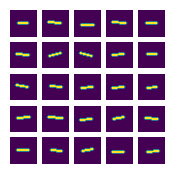

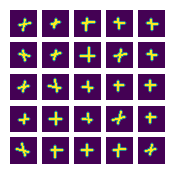

In [3]:
from scipy.ndimage import rotate
# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [4]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

11490434/11490434 [==============================] - 0s 0us/step
(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #2571

X_text: "12-85" = y_text: "-73"


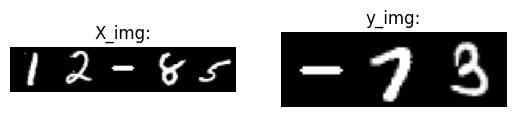

Query #3701

X_text: "18-50" = y_text: "-32"


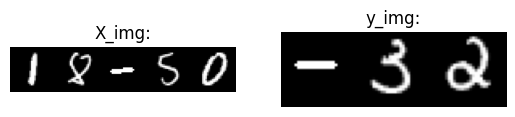

Query #5986

X_text: "29+93" = y_text: "122"


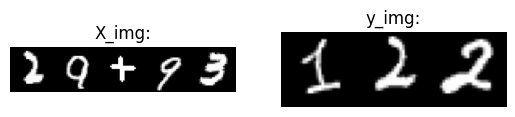

Query #3605

X_text: "18-2 " = y_text: "16 "


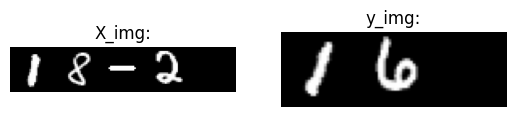

Query #8640

X_text: "43+20" = y_text: "63 "


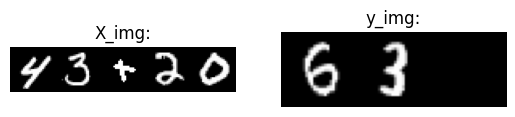

Query #8878

X_text: "44+39" = y_text: "83 "


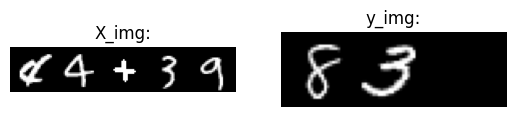

Query #7262

X_text: "36+31" = y_text: "67 "


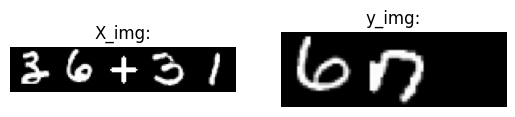

Query #5392

X_text: "26+96" = y_text: "122"


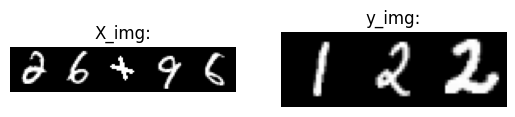

Query #8062

X_text: "40+31" = y_text: "71 "


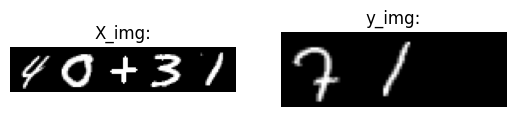

Query #6202

X_text: "31+1 " = y_text: "32 "


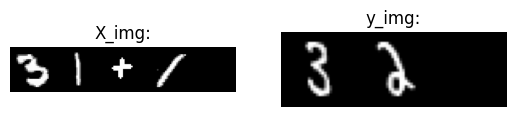

In [5]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [6]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=-1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [ ]:
def build_text2text_model(additional_lstm=False):

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters.
    # Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    if additional_lstm:
        text2text.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))
        text2text.add(LSTM(256, return_sequences=True))
        text2text.add(LSTM(256, return_sequences=True))
        text2text.add(LSTM(256, return_sequences=True))
        text2text.add(LSTM(256))

    else:
        text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step.
    # Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far
    # in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [ ]:
## Your code (look at the assignment description for your tasks for text-to-text model):

def get_data(test_fraction=.1):
    X_text, _, y_text, _ = create_data(highest_integer=99, operands=['+', '-'])
    rng = np.random.default_rng(seed=123)
    indices = rng.permutation(len(y_text))

    X_text = encode_labels(X_text[indices])
    y_text = encode_labels(y_text[indices])

    return X_text, y_text
    # num_test = int(test_fraction*len(y_text))
    # X_train, X_test = X_text[num_test:], X_text[:num_test]
    # y_train, y_test = y_text[num_test:], y_text[:num_test]

    # return (X_train, y_train), (X_test, y_test)

X_text_shuffled, y_text_shuffled = get_data()

models = []
histories = []
testfracs = [
            0.1,
            0.25,
            0.5,
            0.75,
            0.9,
            ]

for frac in testfracs:
    print(f"Validation fraction: {frac:.0%}")
    # traindata, testdata = get_data(test_fraction=frac)
    # X_text, _, y_text, _ = create_data(highest_integer=99, operands=['+', '-'])

    text2textmodel = build_text2text_model(additional_lstm=False)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                      monitor='val_loss',
                                                      restore_best_weights=True)

    num_test = int(frac * len(y_text))
    history = text2textmodel.fit(X_text_shuffled[num_test:], y_text_shuffled[num_test:],
                                 batch_size=32,
                                 epochs=200,
                                 validation_data=(X_text_shuffled[:num_test], y_text_shuffled[:num_test]),
                                 callbacks=[early_stopping_cb],
                                 )

    histories.append(history)
    models.append(text2textmodel)

# get_data()

In [6]:
def onehot_to_integers(labels):
    argmaxes = np.argmax(labels, axis=-1)
    string_list = np.array([''.join([unique_characters[i] for i in pred]) for pred in argmaxes])
    edge_cases = {'-  ': '100',
                 ' ': ''}

    output = np.copy(string_list)
    for i, string in enumerate(string_list):
        try:
            integer = int(string)
        except ValueError:
            integer = 55
        output[i] = integer

    return output.astype(int)


def get_pred_true_mistakes(model, testfrac):
    print("deprecated- pls don't use this one anymore")
    num_test = int(testfrac * len(y_text_shuffled))
    test_in_onehot = X_text_shuffled[:num_test]
    test_true_onehot = y_text_shuffled[:num_test]

    test_pred_onehot = model.predict(test_in_onehot)
    test_pred_int = onehot_to_integers(labels=test_pred_onehot)
    test_true_int = onehot_to_integers(labels=test_true_onehot)
    mistakes_mask = np.where(test_true_int != test_pred_int)

    return test_pred_int, test_true_int, mistakes_mask


def get_pred_true_mistakes_generic(model, X_test, y_test):
    test_pred_onehot = model.predict(X_test)
    test_pred_int = onehot_to_integers(labels=test_pred_onehot)
    test_true_int = onehot_to_integers(labels=y_test)
    mistakes_mask = np.where(test_true_int != test_pred_int)

    return test_pred_int, test_true_int, mistakes_mask


def make_confmatrices(models, testfracs, modeltype: str = 'test'):
    fig, (axs_tens, axs_ones) = plt.subplots(2,len(models),
                                             figsize=[3*len(models),6],
                                             layout='constrained',
                                            )
    if 'tt' in modeltype:
        X_full, _, y_full, _ = create_data(highest_integer=99, operands=['+', '-'])
    elif 'it' in modeltype:
        _, X_full, y_full, _ = create_data(highest_integer=99, operands=['+', '-'])
    else:
        print('wait what typa model is this? Wanna try again?')
        return

    rng = np.random.default_rng(seed=123)
    indices = rng.permutation(len(y_full))
    if 'tt' in modeltype:
        X_full_shuffled = encode_labels(X_full[indices])
    else: # assume image to text, so X_full just needs a reshape
        X_full_shuffled = X_full[indices].reshape((-1, 5, 28*28))

    y_full_shuffled = encode_labels(y_full[indices])

    ### Make 10x10 confusion matrices: for the tens and ones places.
    ### Expect: tens place fuzzy diagonal, bigger scatter on the ones
    import colorcet as cc
    from matplotlib import colors
    for i, model in enumerate(models[::-1]):
        i = len(models) - i -1
        testfrac = testfracs[i]
        num_test = int(testfrac * len(y_full_shuffled))
        X_test = X_full_shuffled[:num_test]
        y_test = y_full_shuffled[:num_test]

        test_pred_int, test_true_int, mistakes = get_pred_true_mistakes_generic(model, X_test, y_test)
#         print(mistakes[0].shape)

        bins = np.arange(0, 11, 1)
        ax_ten, ax_one = axs_tens[i], axs_ones[i]

        ax_ten.hist2d(test_pred_int[mistakes]//10%10, test_true_int[mistakes]//10%10,
                      bins=bins,
#                       norm='symlog',
                      cmap='cet_CET_CBTL3',
                    )
        ax_ten.set_xlim(0, 10)
        ax_ten.set_ylim(0, 10)

        ax_one.hist2d(test_pred_int[mistakes]%10, test_true_int[mistakes]%10,
                      bins=bins,
#                       norm='symlog',
                      cmap='cet_CET_CBTL3',
                  )

        ax_ten.set_title(f'{(1-testfracs[i])*100:.0f}/{(testfracs[i])*100:.0f} split - {1-len(test_true_int[mistakes])/len(test_true_int):.1%} accurate')
        ax_one.tick_params(which='both', direction='in')
        ax_ten.tick_params(which='both', direction='in')

        ax_one.set_xticks(ticks=np.arange(0.5, 10.5, step=1), labels=range(10))
        ax_ten.set_xticks(ticks=np.arange(0.5, 10.5, step=1), labels=range(0, 100, 10))
        ax_one.set_yticks(ticks=np.arange(0.5, 10.5, step=1), labels=range(10))
        ax_ten.set_yticks(ticks=np.arange(0.5, 10.5, step=1), labels=range(0, 100, 10))

        ax_ten.invert_yaxis()
        ax_one.invert_yaxis()
#         ax_ten.xaxis.tick_top()

    ax_one.set_ylabel('Ones digit', rotation=90)
    ax_ten.set_ylabel('Tens digit', rotation=90)


    plt.savefig(f"fig_{modeltype}_confusionmatrices.pdf")
    plt.savefig(f"fig_{modeltype}_confusionmatrices.png")
    plt.show()

# import matplotlib
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# plot_error_freq_per_input(models[0], testfracs[0])
# for model, testfrac in zip(models, testfracs):
#     print(testfrac)
#     make_confmatrices(model, 0.5)


# visualize_mistakes(models[0], testfracs[0])
### Scatter error magnitudes as a function of first and second integer inputs
#     ax1.scatter(input_firsthalf_int[mistakes], test_pred_int[mistakes] - test_true_int[mistakes],
#                    color='firebrick', alpha=.1, )
#     ax2.scatter(input_secondhalf_int[mistakes], test_pred_int3mistakes] - test_true_int[mistakes],
#                    color='firebrick', alpha=.1, )

In [ ]:
make_confmatrices(models, testfracs, modeltype='tt_test')
# plt.rc('text', usetex = True)
# plt.rc('axes', labelsize='x-large')
# plt.rc('xtick',labelsize=10)
# plt.rc('ytick',labelsize=10)
# plt.rc('ytick', direction="in")
# plt.rc('xtick', direction="in")
# plt.rc('axes', facecolor='.975')
# plt.rc('axes', grid=False)

In [7]:
# (Jasper) Inspect convergence of the models above (expectation: larger test fraction means slower convergence but better generalization, at least up to a point)
def make_convergence_plots(histories):
    fig, axes = plt.subplots(1,3, figsize=[10,3])
    for history, ax in zip(histories, axes):
        ax.plot(history.history['accuracy'])
    plt.show()

def plot_testfraction_convergence(histories, testfracs, modeltype='tt'):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10,3], sharey=True, layout='constrained')
    for history, testfrac, color in zip(histories, testfracs, ['forestgreen', 'maroon', 'goldenrod', 'darkblue', 'darkgrey']):
        val_hist = np.array(history.history['val_accuracy'])
        train_hist = np.array(history.history['accuracy'])
        ax1.plot(train_hist, ls='-', color=color, label=f'{testfrac:.0%} test')
        ax2.plot(val_hist, ls='-', color=color, label=testfrac)

    ax1.set_title('Train')
    ax2.set_title('Test')
#     ax1.set_yscale('log')
    ax1.legend()
    ax1.tick_params(which='both', direction='in')
    ax2.tick_params(which='both', direction='in')

    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')

    plt.savefig(f'fig_{modeltype}_convergence.pdf')
    plt.savefig(f'fig_{modeltype}_convergence.png')
    plt.show()



# make_convergence_plots(histories)
# plot_testfraction_convergence(histories, testfracs, modeltype='it_test')


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [ ]:
def build_image2text_model(additional_lstm=False):
    max_answer_length = 3               # Output: 3 digits

    image2text = tf.keras.Sequential()
    if additional_lstm:
        image2text.add(LSTM(256, input_shape=(None, 28*28), return_sequences=True))
        image2text.add(LSTM(256, return_sequences=True))
        image2text.add(LSTM(256, return_sequences=True))
        image2text.add(LSTM(256, return_sequences=True))
        image2text.add(LSTM(256))

    else:
        image2text.add(LSTM(256, input_shape=(None, 28*28)))  # "Encode" the input images using an RNN, producing an output of size 256.

    image2text.add(RepeatVector(max_answer_length))     # The RNN will always produce 3 characters as its output.

    image2text.add(LSTM(256, return_sequences=True))    # Setting return_sequences to True as TimeDistributed expects the first dimension to be the timesteps.

    image2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.

    image2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    image2text.summary()

    return image2text

def get_split_data_i2t(testfrac: float = .75):
    _, X_img, y_text, _ = create_data(highest_integer=99, operands=['+', '-'])
    num_test = int(testfrac  * len(y_text))

    rng = np.random.default_rng(seed=123)
    indices = rng.permutation(len(y_text))
    X_img = X_img[indices].reshape((-1, 5, 28*28))
    y_text = encode_labels(y_text[indices])

    X_test, X_train = X_img[:num_test], X_img[num_test:]
    y_test, y_train = y_text[:num_test], y_text[num_test:]

    return X_train, y_train, X_test, y_test


In [ ]:

models = []
histories = []
testfracs = [
            0.1,
            0.25,
            0.5,
            0.75,
            0.9,
            ]

for frac in testfracs:
    print(f"Validation fraction: {frac:.0%}")
    image2textmodel = build_image2text_model(additional_lstm=False)

    X_train, y_train, X_test, y_test = get_split_data_i2t(testfrac=frac)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                      monitor='val_loss',
                                                      restore_best_weights=True)

    history = image2textmodel.fit(X_train, y_train,
                                 batch_size=32,
                                 epochs=100,
                                 validation_data=(X_test, y_test),
                                 callbacks=[early_stopping_cb],
                                 )

    histories.append(history)
    models.append(image2textmodel)
# accuracy is diff number on plot than in history??? how come? wacky accuracy definition in keras? wacky def in my code?
# should be just num correct divided by num total, right?

In [ ]:
make_confmatrices(models, testfracs, modeltype='it_test')
plot_testfraction_convergence(histories, testfracs, modeltype='it_test')

In [ ]:
num = np.random.randint(0,10000,1)
print('Random number: ', num, ' X_text:', X_text[num], ' y_text:', y_text[num])
for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        #plt.title(labels[i])
        plt.imshow(np.hstack(data[num][0]), cmap='gray')
prediction = image2textmodel.predict(im_train[num].reshape(1,5,28*28))
print('Model prediction: ', onehot_to_integers(prediction))

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [ ]:
# Your code

def build_text2image_model(additional_lstm=False):
    """just ripped the text2text lol... sumfunny is probs gonna be needed- at least replacing the last layer (?)"""
    # We start by initializing a sequential model
    text2image = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    if additional_lstm:
        text2image.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))
        # text2image.add(LSTM(256, return_sequences=True))
        # text2image.add(LSTM(256, return_sequences=True))
        text2image.add(LSTM(256, return_sequences=True))
        text2image.add(LSTM(256))

    else:
        text2image.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2image.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2image.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2image.add(TimeDistributed(Dense(28*28, activation='sigmoid')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2image.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    text2image.summary()

    return text2image

def get_text2image_data():
    X_text, _, _, y_img = create_data(highest_integer=99, operands=['+', '-'])
    rng = np.random.default_rng(seed=123)
    indices = rng.permutation(len(y_img))

    X_text = encode_labels(X_text[indices])
    y_img = y_img[indices].reshape((-1, 3, 28*28))

    return X_text, y_img

X_text_shuffled, y_img_shuffled = get_text2image_data()

ti_models = []
ti_histories = []
ti_testfracs = [
            0.1,
            0.25,
            0.5,
            0.75,
            0.9,
            ]

for frac in ti_testfracs:
    print(f"Validation fraction: {frac:.0%}")
    text2imgmodel = build_text2image_model(additional_lstm=True)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                      monitor='val_loss',
                                                      restore_best_weights=True)

    num_test = int(frac * len(y_img_shuffled))
    history = text2imgmodel.fit(X_text_shuffled[num_test:], y_img_shuffled[num_test:],
                                 batch_size=32,
                                 epochs=200,
                                 validation_data=(X_text_shuffled[:num_test], y_img_shuffled[:num_test]),
                                 callbacks=[early_stopping_cb],
                                 )

    ti_histories.append(history)
    ti_models.append(text2imgmodel)

# get_data()




Validation fraction: 10%
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_90 (LSTM)              (None, None, 256)         276480    
                                                                 
 lstm_91 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_92 (LSTM)              (None, 256)               525312    
                                                                 
 repeat_vector_17 (RepeatVe  (None, 3, 256)            0         
 ctor)                                                           
                                                                 
 lstm_93 (LSTM)              (None, 3, 256)            525312    
                                                                 
 time_distributed_17 (TimeD  (None, 3, 784)            201488    
 istributed)                

In [ ]:
def plot_output(models, testfracs):
    n_samples = 4
    grid_shape = [n_samples, len(models)] # nrows, ncols of plot
    text_in = np.array([decode_labels(X_text_shuffled[i]) for i in range(n_samples)]).reshape(n_samples)
    img_true = y_img_shuffled[:n_samples].reshape(-1, 3, 28, 28)
    fig, axes = plt.subplots(n_samples, len(models),
                             figsize=[grid_shape[1]*2.5, grid_shape[0]*1.75],
                             layout='constrained',
                            )

    for ax_col, model, testfrac in zip(axes.T, models, testfracs):
        img_out = model.predict(encode_labels(text_in.flatten()))
#         ax_col = axes[:,i]
        ax_col[0].set_title(f'{testfrac:.0%} test')
        for img, ax, target, prompt in zip(img_out, ax_col, img_true, text_in):
            combined_image = np.hstack(img.reshape(3, 28, 28))
            target_image = np.hstack(target)
            vertical_stack = np.vstack([target_image, combined_image])
            ax.set_aspect('equal')
            ax.axis('off')
#             ax.set_title(prompt)
            ax.imshow(vertical_stack, cmap='Greys_r')
#     fig.set_constrained_layout(True)
#     fig.set_tight_layout(True)
#     plt.subplots_adjust(hspace=.1)
    plt.savefig(f"fig_ti_deep2_output_tf{int(testfrac*100)}.png")
    plt.savefig(f"fig_ti_deep2_output_tf{int(testfrac*100)}.pdf")
    plt.show()

# for ti_model, ti_testfrac in zip(ti_models, ti_testfracs):
plot_output(ti_models, ti_testfracs)

# seems like convergence is kind of hard to track, and the net doesn't train particularly quickly. BUT! after a while (like 50-100 epochs) the output starts to look kind of decent
# just text2text but with 28x28 sigmoid dense nodes in the final (TD) layer, and using mse loss
# I guess this doensn't really 'make mistakes' in the same way as the previous ones? idk- I guess this model is less confidently incorrect
# I've only tried 50/50 train/test

# Sometimes it's off by just 1 though - I'm looking at 92-83 after 50 epochs and it looks like it's really tempted to say 10
# also, -29 and -30 (from 60-90)
# seems like the ones place is the most fragile/fuzzy (just like with the text2text), which is interesting because that's not something we train explicitly.
# I guess the LSTM cells just don't really know how to use the info correctly or something?
# also now it confuses digits that just look similar (8 and 9, 5 and 6). Or at least it looks like it does

# larger test fraction makes the t2i confused I think. Shouldn't get in the way of the math too much, but then again maybe it does because now there's similarity between eights and sixes.
# since these are testing images, they are not used for training. You can see that reflected in how the predicted number shapes don't match the 'correct' ones. The network is clearly not just memorizing here.

In [ ]:
def plot_output(models, testfracs):
    n_samples = 15
    grid_shape = [len(models), 1] # nrows, ncols of plot
    text_in = np.array([decode_labels(X_text_shuffled[i]) for i in range(n_samples)]).reshape(n_samples)
    img_true = y_img_shuffled[:n_samples].reshape(-1, 3, 28, 28)
    fig, axes = plt.subplots(1, len(models),
#                              figsize=[grid_shape[1]*2.5, grid_shape[0]*1.75],
                             layout='constrained',
                            )

    for ax, model, testfrac in zip(axes, models, testfracs):
        model_predictions = model.predict(encode_labels(text_in)).reshape((n_samples, 3, 28, 28))
        predictions_stacked = np.array([np.hstack(pred) for pred in model_predictions])
        full_image = np.vstack(predictions_stacked)

        ax.imshow(full_image, cmap='Greys_r')
#         ax.set_aspect('equal')
        ax.axis('off')
    plt.show()

plot_output(ti_models, ti_testfracs)

1/1 [==============================] - 0s 21ms/step


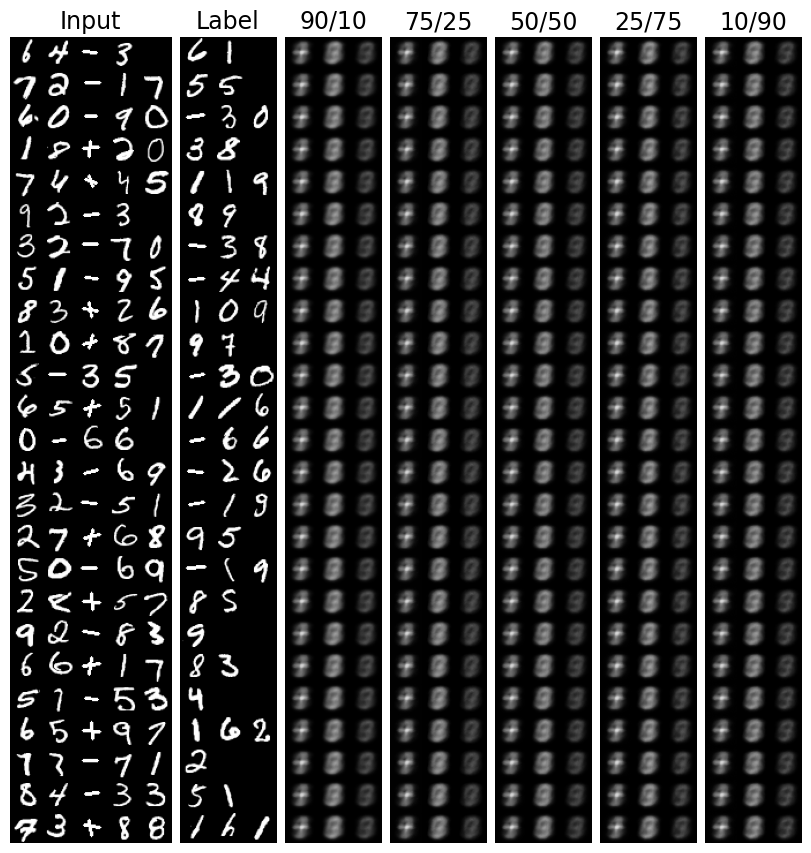

In [17]:
def get_text2image_data_for_examples():
    X_text, X_img, _, y_img = create_data(highest_integer=99, operands=['+', '-'])
    rng = np.random.default_rng(seed=123)
    indices = rng.permutation(len(y_img))

    X_text = encode_labels(X_text[indices])
    X_img = X_img[indices].reshape((-1, 5, 28*28))
    y_img = y_img[indices].reshape((-1, 3, 28*28))

    return X_text, y_img, X_img


def plot_output(models, testfracs):
    n_samples = 25
    X_text_shuffled, y_img_shuffled, X_img_shuffled = get_text2image_data_for_examples()
    text_in = np.array([decode_labels(X_text_shuffled[i]) for i in range(n_samples)]).reshape(n_samples)
    img_true = y_img_shuffled[:n_samples].reshape(-1, 3, 28, 28)
    img_in = X_img_shuffled[:n_samples].reshape(-1, 5, 28, 28)
    fig, axes = plt.subplots(1, len(models)+2,
                             figsize=[(len(models)+3)*3/3, (n_samples+2)*1/3],
                             layout='constrained',
                             width_ratios=[5, 3, 3, 3, 3, 3, 3],
                            )

    for ax, model, testfrac in zip(axes[2:], models, testfracs):
        model_predictions = model.predict(encode_labels(text_in)).reshape((n_samples, 3, 28, 28))
        predictions_stacked = np.array([np.hstack(pred) for pred in model_predictions])
        full_image = np.vstack(predictions_stacked)

        ax.imshow(full_image, cmap='Greys_r', vmin=0, vmax=1)
        ax.set_title(f'{(1-testfrac)*100:.0f}/{(testfrac)*100:.0f}', size=17)
#         ax.set_aspect('equal')
        ax.axis('off')

    true_images_concat = np.array([np.hstack(img) for img in img_true])
    full_true = np.vstack(true_images_concat)
    axes[1].imshow(full_true, cmap='Greys_r')
    axes[1].axis('off')
    axes[1].set_title('Label', size=17)

    in_images_concat = np.array([np.hstack(img) for img in img_in])
    full_in = np.vstack(in_images_concat)
    axes[0].imshow(full_in, cmap='Greys_r')
    axes[0].axis('off')
    axes[0].set_title('Input', size=17)

    plt.savefig('fig_ti_deep4_examples.pdf')

    plt.show()


plot_output(ti_models, ti_testfracs)

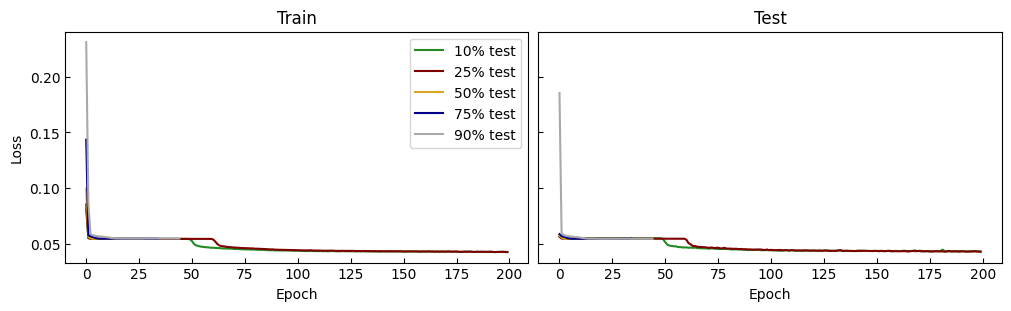

In [14]:
def plot_testfraction_convergence(histories, testfracs, modeltype='tt'):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10,3], sharey=True, layout='constrained')
    for history, testfrac, color in zip(histories, testfracs, ['forestgreen', 'maroon', 'goldenrod', 'darkblue', 'darkgrey']):
        val_hist = np.array(history.history['val_loss'])
        train_hist = np.array(history.history['loss'])
        ax1.plot(train_hist, ls='-', color=color, label=f'{testfrac:.0%} test')
        ax2.plot(val_hist, ls='-', color=color, label=testfrac)

    ax1.set_title('Train')
    ax2.set_title('Test')
#     ax1.set_yscale('log')
    ax1.legend()
    ax1.tick_params(which='both', direction='in')
    ax2.tick_params(which='both', direction='in')

    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')

    plt.savefig(f'fig_{modeltype}_convergence.pdf')
    plt.show()

plot_testfraction_convergence(ti_histories, ti_testfracs, modeltype='ti_deep2')